In [1]:
from weather_predictor import preprocess_data_for_n_days_ahead, create_and_train_model

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


I downloaded a weather history from idojarasbudapest.hu using a python script. You can find the script in dataset_downloader.py.

In [2]:
df = pd.read_csv('data/weather_dataset.csv') # read downloaded dataset
n_data_to_show = 20 # we want to see the first 20 data
data = np.array(df) # convert it to numpy array, it's easier to hadle
data = data[:n_data_to_show, :4] # select the first 4 columns

### Visualizing
Plotting the first 20 data in the history dataset: min. and max temperature.

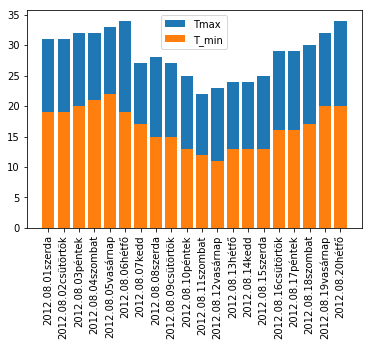

In [3]:
plt.xticks(rotation=90)
_ = plt.bar(np.arange(n_data_to_show), data[:, 1], tick_label=data[:, 0])
_ = plt.bar(np.arange(n_data_to_show), data[:, 2], tick_label=data[:, 0])
_ = plt.legend(['Tmax', 'T_min'])

Plotting the wind strength.

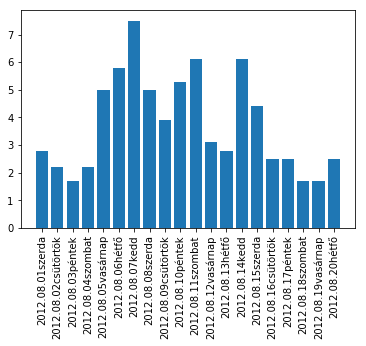

In [4]:
plt.xticks(rotation=90)
_ = plt.bar(np.arange(n_data_to_show), data[:, 3], tick_label=data[:, 0])

### Preprocessing the data
To train a model first we have to preprocess the data.
Prepocessing steps are:
    1. we select the appropriate columns: T_min, T_max, wind_speed
    2. we make inputs and outputs; if we want to make predictions for n days then:
        inputs: we select all the datas except the last n days
        outputs: we select all the datas except the first n days
    3. we shuffle the data
    4. we split the data into train-validation and test dataset, Keras can automatically make train-validation split for us
    5. we standard scale the input data: we fit the sklearn's StandardScaler to the training input and scale the train and the test input
    6. we minmax scale the output data: we fit the sklearn's MinMaxScaler to the training output and scale the train and test output
You can find the whole algorithm in the weather_predictor.py module in the preprocess_data_for_n_days_ahead function.

In [5]:
n_days = 1 # we want to train a model to predict for 1 day 
#(you can change it if you want to train a model to predict for more days)
(x_train, y_train), (x_test, y_test), ssc, mmsc = preprocess_data_for_n_days_ahead(n_days, 0.9) # preprocesing

### Creating and training the model
In the next step we create a model with [256, 128, 64, 31, 1] neurons. I'm using LeakyReLU activation in the hidden layers and linear activation in the last layer.
I'm using the ModelCheckPoint callback to save the model with the best validation result. I'm also using EarlyStopping callback so that if the loss doesn't change min 0.0001 for 10 epoch then the training terminates.
You can find this code in the weather_predictor.py module in the create_and_train_model function.

In [6]:
input_shape=x_train[0].shape[0] # shape of input data
model_name = 'model_{}_days'.format(n_days)
model = create_and_train_model(input_shape=input_shape, x=x_train, y=y_train, model_name=model_name) # we create a model and train it

Train on 2007 samples, validate on 224 samples
Epoch 1/100
2007/2007 [==============================] - 11s 5ms/step - loss: 0.0297 - val_loss: 0.0324
Epoch 2/100
2007/2007 [==============================] - 1s 571us/step - loss: 0.0241 - val_loss: 0.0319
Epoch 3/100
2007/2007 [==============================] - 1s 581us/step - loss: 0.0239 - val_loss: 0.0341
Epoch 4/100
2007/2007 [==============================] - 1s 576us/step - loss: 0.0230 - val_loss: 0.0327
Epoch 5/100
2007/2007 [==============================] - 1s 571us/step - loss: 0.0232 - val_loss: 0.0343
Epoch 6/100
2007/2007 [==============================] - 1s 587us/step - loss: 0.0236 - val_loss: 0.0325
Epoch 7/100
2007/2007 [==============================] - 1s 584us/step - loss: 0.0223 - val_loss: 0.0359
Epoch 8/100
2007/2007 [==============================] - 1s 594us/step - loss: 0.0231 - val_loss: 0.0342
Epoch 9/100
2007/2007 [==============================] - 1s 591us/step - loss: 0.0230 - val_loss: 0.0320
Epoch 10/

### Making predictions and transforming back
Since we get the predictions using a model that learned minmax scaled data we have to transfrom back the results.

In [7]:
predictions = model.predict(x_test) # we make predictions
predictions = mmsc.inverse_transform(predictions.reshape(-1, 1)).reshape(-1) # transform back minmax scale
y_test = mmsc.inverse_transform(y_test.reshape(-1, 1)).reshape(-1) # transform back minmax scale

for pred, y in zip(predictions[:n_data_to_show], y_test[:n_data_to_show]): # print
    print('Predicted: {0:.2f}°C desired: {1:.2f}°C'.format(pred, y))


Predicted: 9.45°C desired: 5.00°C
Predicted: 1.61°C desired: 5.00°C
Predicted: 8.91°C desired: 12.50°C
Predicted: 8.37°C desired: 8.00°C
Predicted: 16.16°C desired: 17.00°C
Predicted: 9.12°C desired: 11.00°C
Predicted: 1.67°C desired: 10.00°C
Predicted: 1.51°C desired: 8.00°C
Predicted: 3.03°C desired: 2.50°C
Predicted: 14.83°C desired: 10.00°C
Predicted: 26.83°C desired: 27.00°C
Predicted: 5.00°C desired: 6.50°C
Predicted: 26.78°C desired: 27.50°C
Predicted: 4.64°C desired: 2.50°C
Predicted: 23.74°C desired: 24.80°C
Predicted: 25.43°C desired: 27.00°C
Predicted: 0.60°C desired: -4.00°C
Predicted: 16.77°C desired: 20.50°C
Predicted: 20.03°C desired: 21.50°C
Predicted: 20.59°C desired: 17.00°C


### Plotting results

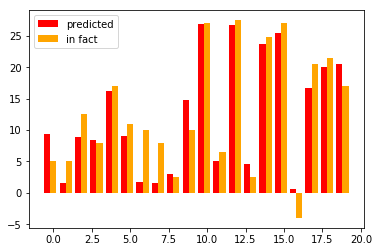

In [8]:
ax = plt.subplot(111)
w = 0.4
_ = ax.bar(np.arange(n_data_to_show)-w, predictions[:n_data_to_show],width=w,color='red',align='center')
_ = ax.bar(np.arange(n_data_to_show), y_test[:n_data_to_show],width=w,color='orange',align='center')
_ = ax.legend(['predicted', 'in fact'])